In [27]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [28]:
# Window version
# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# M1 MAC version
DEVICE = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

print(DEVICE)

mps


In [29]:
BATCH_SIZE = 32
LR = 1e-3
EPOCH = 5
criterion = nn.CrossEntropyLoss()
new_model_train = True
model_type = 'MLP'
dataset = "MNIST"
save_model_path = f'your path/result/{model_type}_{dataset}.pt'

In [30]:
transform = transforms.ToTensor()
train_DS = datasets.MNIST(root='your path/data', train=True, download=True, transform=transform)
test_DS = datasets.MNIST(root='your path/data', train=False, download=True, transform=transform)
train_DL = torch.utils.data.DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=True)

In [31]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.linear = nn.Sequential(
            nn.Linear(28*28, 100),
            nn.ReLU(),
            nn.Linear(100, 10))
        
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = self.linear(x)
        return x

In [32]:
exec(f'model = {model_type}()')
print(model)

MLP(
  (linear): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)


In [33]:
def Train(model, train_DL, criterion, optimizer):
    loss_history = []
    model.train()
    for it in range(EPOCH):
        eloss = 0
        for x_batch, y_batch in train_DL:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)

            y_hat = model(x_batch)
            loss = criterion(y_hat, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss = loss.item() * x_batch.shape[0]
            eloss += loss
        eloss /= len(train_DL.dataset)
        loss_history += [eloss]
        print(f'Epoch: {it+1}, Train Loss: {round(eloss, 3)}')
        print('-'*30)
    return loss_history

def Test(model, test_DL):
    model.eval()
    with torch.no_grad():
        rcorrect = 0
        for x_batch, y_batch in test_DL:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)

            y_hat = model(x_batch)
            pred = y_hat.argmax(dim=1)
            correct_b = torch.sum(pred == y_batch).item()
            rcorrect += correct_b
        accuracy_e = rcorrect/len(test_DL.dataset) * 100
    print(f'Test accuracy: {rcorrect}/{len(test_DL.dataset)} ({round(accuracy_e, 2)} %)')

def Test_plot(model, test_DL):
    model.eval()
    with torch.no_grad():
        x_batch, y_batch = next(iter(test_DL))
        x_batch = x_batch.to(DEVICE)
        y_hat = model(x_batch)
        pred = y_hat.argmax(dim=1)
    x_batch = x_batch.to('cpu')

    plt.figure(figsize=(8,4))
    for idx in range(6):
        plt.subplot(2, 3, idx+1, xticks=[], yticks=[])
        plt.imshow(x_batch[idx].permute(1,2,0).squeeze(), cmap='gray')
        pred_class = test_DL.dataset.classes[pred[idx]]
        true_class = test_DL.dataset.classes[y_batch[idx]]
        plt.title(f'({pred_class}) ({true_class})', color='g' if pred_class==true_class else 'r')

def count_params(model):
    num = sum([p.numel() for p in model.parameters() if p.requires_grad])
    return num

Epoch: 1, Train Loss: 0.311
------------------------------
Epoch: 2, Train Loss: 0.142
------------------------------
Epoch: 3, Train Loss: 0.1
------------------------------
Epoch: 4, Train Loss: 0.076
------------------------------
Epoch: 5, Train Loss: 0.06
------------------------------


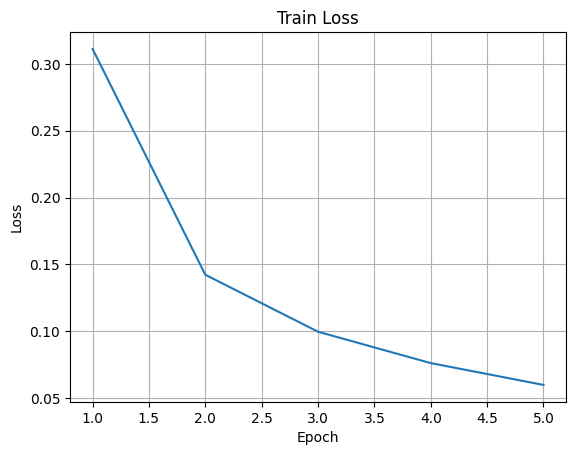

In [34]:
if new_model_train:
    model = model.to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    loss_history = Train(model, train_DL, criterion, optimizer)

    torch.save(model, save_model_path)

    plt.plot(range(1, EPOCH+1), loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train Loss')
    plt.grid()

In [35]:
load_model = torch.load(save_model_path)

In [36]:
Test(load_model, test_DL)
print(count_params(load_model))

Test accuracy: 9759/10000 (97.59 %)
79510


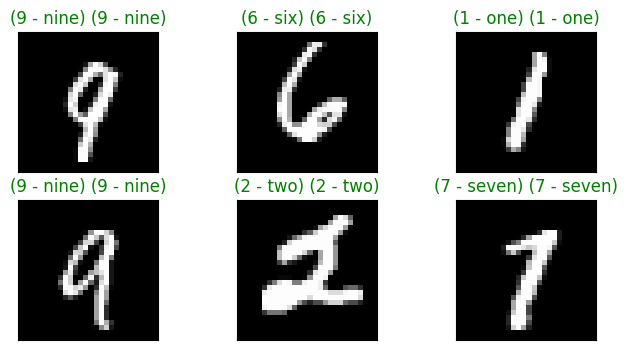

In [37]:
Test_plot(load_model, test_DL)